In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [2]:
# svg, png. no inline pdf.

# mpl inches conversion:
# 5in x 5in   => 279px x 279px
# 10in x 10in => 558px x 558px

# presentation for Markdown mixu:
# width:
#   content column width  = 760px = 13.62 in
# height:
#   max viewport height   = 857px = 15.36 in
#   ideal viewport height = 260px = 4.66 in
# 
# max width 760
# 10 inches -> 760px width
# 5 inches -> 279px width

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas
import mpld3
#mpld3.enable_notebook()

from mpl_toolkits.basemap import Basemap
#import seaborn as sns

In [4]:
from matplotlib.patches import Polygon

In [5]:
import numpy as np
import scipy
import scipy.stats

In [6]:
import sklearn
import sklearn.decomposition
import sklearn.feature_extraction
import sklearn.feature_extraction.text

In [7]:
import collections
from pprint import pprint
import cPickle as pickle
import unicodecsv as csv
import json
import re

In [8]:
import analysis_tools

In [9]:
np.seterr(divide='raise', over='raise', under='raise', invalid='raise');

# Data preparation

Let's load the cities. We'll filter out any groups that weren't 'active' during the period of study (2012-2014, inclusive; three years). Active groups are those that have had an event with at least two attendees.

In [10]:
all_city2groups = analysis_tools.get_city2groups('GB')

db_all_groups = sum(all_city2groups.itervalues(), [])
    # all groups loaded from DB, including those not assigned to cities
print "all gorups, inc without cities", len(db_all_groups)

all gorups, inc without cities 1588


In [11]:
print "number of groups without city", len(all_city2groups.get('<unknown>', []))
if '<unknown>' in all_city2groups:
    del all_city2groups['<unknown>']

num_grps_before_filter = sum(len(groups) for groups in all_city2groups.itervalues())
print "number of groups before filtering:", num_grps_before_filter

number of groups without city 47
number of groups before filtering: 1541


In [12]:
def is_active(grp):
    for event in grp['events_in_window']:
        if len(event['attendee_ids']) >= 2:
            return True
    return False
        
for city_ident in all_city2groups.iterkeys():
    all_city2groups[city_ident] = filter(is_active, all_city2groups[city_ident])
    
num_grps_after_filter = sum(len(groups) for groups in all_city2groups.itervalues())
print "number of groups after filtering:", num_grps_after_filter

number of groups after filtering: 932


How many usable groups do we have per city?

In [13]:
group_counts = collections.Counter({city: len(groups) for city, groups in all_city2groups.iteritems()})

for indx, (k, v) in enumerate(group_counts.most_common()):
    print "%-10s%-10s%-30s(pop %d)" % (indx+1, v, k, k.pop)
print "..."

1         588       UK::London                    (pop 12972492)
2         44        UK::Bristol metropolitan area (pop 1059746)
3         39        UK::Manchester metropolitan area(pop 2460991)
4         34        UK::Cambridge                 (pop 361461)
5         28        UK::Birmingham metropolitan area(pop 3621263)
6         26        UK::Edinburgh                 (pop 214846)
7         20        UK::Brighton/Worthing/Littlehampton(pop 566617)
8         16        UK::Oxford                    (pop 311481)
9         15        UK::Leeds - Bradford metropolitan area(pop 2210426)
10        11        UK::Liverpool/Birkenhead metropolitan area(pop 2060653)
11        10        UK::Cardiff and South Wales valleys metropolitan area(pop 1142941)
12        9         UK::Leicester                 (pop 747425)
13        8         UK::Norwich                   (pop 428646)
14        7         UK::Belfast                   (pop 857106)
15        7         UK::Tyneside metropolitan area(pop 139

In [14]:
print len(group_counts)

54


In [15]:
min_num_groups = 5
keep_cities = [city for city, count in group_counts.iteritems() if count >= min_num_groups]

print "%d cities with at least %s Tech groups:" % (len(keep_cities), min_num_groups)
print ', '.join(map(str, keep_cities))

city2groups = {city: all_city2groups[city] for city in keep_cities}  # all cities for study

18 cities with at least 5 Tech groups:
UK::Norwich, UK::Glasgow, UK::Birmingham metropolitan area, UK::Belfast, UK::Liverpool/Birkenhead metropolitan area, UK::Cardiff and South Wales valleys metropolitan area, UK::Leicester, UK::Oxford, UK::Edinburgh, UK::Tyneside metropolitan area, UK::London, UK::Manchester metropolitan area, UK::Cambridge, UK::Brighton/Worthing/Littlehampton, UK::Bristol metropolitan area, UK::Nottingham-Derby metropolitan area, UK::Leeds - Bradford metropolitan area, UK::Sheffield metropolitan area


In [16]:
num_study_grps = sum(len(groups) for groups in city2groups.itervalues())
print "groups crawled (before filtering)                  ", num_grps_before_filter
print "active groups (after filtering)                    ", num_grps_after_filter
print "active groups in active cities (focus of analysis) ", num_study_grps

groups crawled (before filtering)                   1541
active groups (after filtering)                     932
active groups in active cities (focus on analysis)  880


### Build dataframe with descriptors of each city

In [17]:
# city name; longitude; latitude;
# population (geodemographic); num users subscribed (unique); num users attended event (unique)
# num events; num meetup groups

def extract_active_users(groups):
    # active = attended at least one event
    uniqs = set()
    for group in groups:
        for event in group['events_in_window']:
            uniqs.update(event['attendee_ids'])
    return tuple(uniqs)
def count_active_users(groups):
    return len(extract_active_users(groups))

def extract_subscribed_users(groups):
    # subscribed = subscribed to at least one group
    uniqs = set()
    for group in groups:
        uniqs.update(group['member_ids'])
    return tuple(uniqs)
def count_subscribed_users(groups):
    return len(extract_subscribed_users(groups))

rows = []
for city, groups in city2groups.iteritems():
    row = collections.OrderedDict()
    pop = float(city.pop)
    row['name'] = str(city)
    row['fua_id'] = str(city.fua_id)
    row['lon'] = city.lon
    row['lat'] = city.lat
    row['pop'] = pop
    row['groups'] = float(len(groups))
        # by way of previous filtering, these are 'active' gruops -- at least one event
        # with two attendees
    row['users_members'] = float(count_subscribed_users(groups))
    row['users_attendees'] = float(count_active_users(groups))
    # population-normed measures:
    row['groups_per_100k'] = row['groups'] / (pop/10**5)
    row['users_members_per_100k'] = row['users_members'] / (pop/10**5)
    row['users_attendees_per_100k'] = row['users_attendees'] / (pop/10**5)
    rows.append(row)

df_cities = pandas.DataFrame(rows, columns=rows[0].keys())
print df_cities

                                                 name   fua_id       lon  \
0                                          UK::London  UK11208 -0.163732   
1                 UK::Brighton/Worthing/Littlehampton  UK11171 -0.165454   
2                       UK::Bristol metropolitan area  UK11172 -2.547128   
3                                       UK::Edinburgh  UK11186 -3.128971   
4              UK::Leeds - Bradford metropolitan area  UK11204 -1.625681   
5          UK::Liverpool/Birkenhead metropolitan area  UK11207 -2.833608   
6                                          UK::Oxford  UK11220 -1.291842   
7                                       UK::Leicester  UK11205 -1.098805   
8                                         UK::Norwich  UK11217  1.286582   
9                    UK::Manchester metropolitan area  UK11212 -2.207738   
10                                        UK::Glasgow  UK11190 -4.340771   
11                                      UK::Cambridge  UK11174  0.196639   
12          

### Other data for future use

In [18]:
# canonical ordering of cities:
all_cities = tuple(sorted(city2groups.iterkeys()))

### Functions for future use

In [19]:
def shortname(city_name):
    if not isinstance(city_name, (str, unicode)):
        city_name = unicode(city_name)
    # return shortname for city. e .g.,
    #     UK::Bristol metropolitan area  ->  Bristol
    match = re.match('^.*:.*:([a-zA-Z]+)[ -/]?.*', city_name)
    if match is None:
        return city_name
    else:
        return match.group(1)
print shortname('UK::London')
print shortname('UK::Glasgow')

London
Glasgow


In [20]:
def add_geometries_fua(bmap, show=True):
    bmap.readshapefile('geometries/fua/fua_uk_wgs84', 'shp_fua', color=(0.5, 0.5, 0.5, 1.0),
                       zorder=1, drawbounds=show, linewidth=0.3)

def add_geometries_london(bmap, show=True):
    bmap.readshapefile('geometries/london/london_boroughs_wgs84', 'shp_london', color=(0.5, 0.5, 0.5, 1.0),
                       zorder=1, drawbounds=show, linewidth=0.3)

def default_basemap(ax, draw_fua=True, draw_london=True, **kwargs):
    # NB, even if draw_* is False, shape data will still be loaded on to
    # the basemap
    # llcrnrlon=-11.372070, llcrnrlat=48.507377, urcrnrlon=2.5, urcrnrlat=59.7
    bmap = Basemap(
                ax=ax,
                rsphere=(6378137.00, 6356752.3142),
                resolution='i', projection='merc',
                lat_0=40., lon_0=-20., lat_ts=20.,
                **kwargs)
    
    #basem.drawcoastlines(color=[0, 0, 0, 0.4])
    #basem.fillcontinents()
    #basem.drawlsmask(land_color=(1,1,1,1), ocean_color='#9AC2EA', lakes=False, resolution='f')
    #basem.drawmapboundary(color='k', fill_color='g')
    
    add_geometries_fua(bmap, draw_fua)
    add_geometries_london(bmap, draw_london)
    
    ax.set_axis_bgcolor('#9AC2EA')
    bmap.fillcontinents(zorder=-1, color=(1.0,1,1,1))
    return bmap

def add_frame(ax, fc='none', ec='#888888', lw=5):
    l, r = ax.get_xlim()
    b, t = ax.get_ylim()
    ax.add_artist(mpl.patches.Rectangle([l,b], r-l, t-b, fc='none', ec='#888888', lw=5))

# Geography of meetups and activity

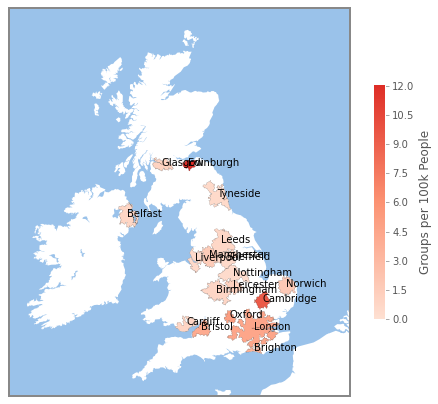

In [21]:
from matplotlib.colors import LinearSegmentedColormap
import palettable

fig, ax = plt.subplots(1, 1,)  # figsize=[30, 6.45]

basem = default_basemap(ax=ax, draw_fua=False, draw_london=False,
                llcrnrlon=-11.372070, llcrnrlat=49.5, urcrnrlon=4.2, urcrnrlat=59.7)

#
# choropleth
mags = df_cities['groups_per_100k'].values

norm = mpl.colors.Normalize(vmin=0, vmax=max(mags))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=palettable.colorbrewer.sequential.Reds_3.get_mpl_colormap())
    #'winter_r' palettable.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap() 'YrOrRd'

cmap.set_array(mags)

fua2shape = dict(zip([info['id_fua'] for info in basem.shp_fua_info], basem.shp_fua))
for mag, (indx, row) in zip(mags, df_cities.iterrows()):
    assert mag == row['groups_per_100k']
    
    #
    fua_id = row['fua_id']
    shp = fua2shape[fua_id]
    poly = Polygon(np.array(shp), True, fc=cmap.to_rgba(mag), lw=0.1, ec='k')
    ax.add_artist(poly)
    
    #
    x, y = basem(row['lon'], row['lat'])
    ax.text(x, y, shortname(row['name']))

add_frame(ax)

cbar = plt.colorbar(cmap, orientation='vertical', shrink=0.6)
cbar.set_label('Groups per 100k People')
cbar.set_clim(vmin=0)

fig.set_size_inches(8.0, 7.0)
fig.savefig('out/uk_choropleth.pdf', bbox_inches='tight', pad_inches=0)

In [22]:
# Where do events happen? 
# Include all groups in the DB (inc. not assigned to city).
# Ignore events w/o venues

seq_lon = []
seq_lat = []
for group in db_all_groups:
    for event in group['events_in_window']:
        if 'venue' not in event:
            continue
        venue = event['venue']
        seq_lon.append(venue['lon'])
        seq_lat.append(venue['lat'])

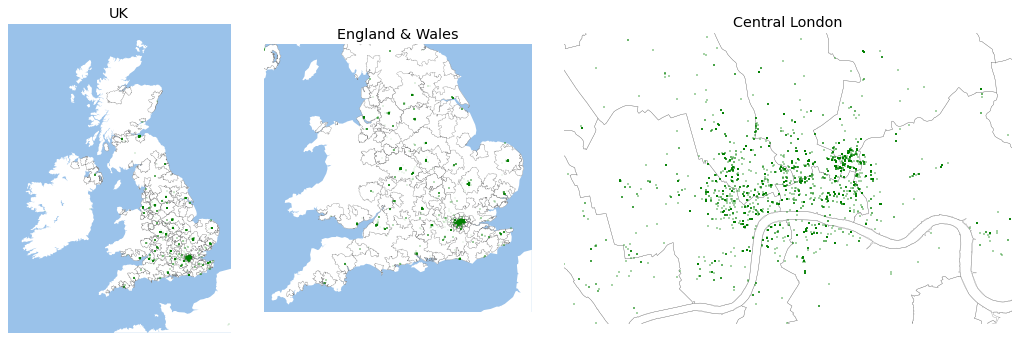

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset 

#
# Basemap
fig = plt.figure(figsize=[18, 12])
#gs = mpl.gridspec.GridSpec(2, 3, wspace=0.02, hspace=0.01)
#ax1 = plt.subplot(gs[:,:-1])
#ax2 = plt.subplot(gs[0,-1])
#ax3 = plt.subplot(gs[1,-1])
gs = mpl.gridspec.GridSpec(1, 3, wspace=0.10, hspace=0.01, width_ratios=[5, 6, 10])
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])

viewports = [
    {'llcrnrlon': -11.372070, 'llcrnrlat': 48.507377, 'urcrnrlon': 2.5, 'urcrnrlat': 59.7},  # UK
    {'llcrnrlon': -5.972070, 'llcrnrlat': 49.807377, 'urcrnrlon': 2.0, 'urcrnrlat': 54.7},  # eng&wal
    {'llcrnrlon': -0.206744, 'llcrnrlat': 51.48, 'urcrnrlon': -0.01, 'urcrnrlat': 51.560},  # Central London
    ]

for ax, view, s, alpha in zip([ax1, ax2, ax3], viewports, [1.5, 1.5, 3.5], [0.2, 0.2, 0.5]):
    basem = default_basemap(ax=ax, draw_fua=True, draw_london=True,**view)
    x, y = basem(seq_lon, seq_lat)
    ax.scatter(x, y, s=s, marker='o', linewidths=0, c='g', alpha=alpha)

ax1.set_title('UK')
ax2.set_title('England & Wales')
ax3.set_title('Central London')


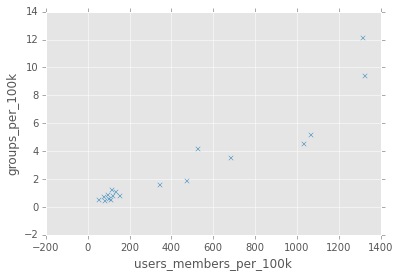

In [24]:
# population, number of groups, number of (unique) active usres (by event attendance)

df_cities.plot(kind='scatter', x='users_members_per_100k', y='groups_per_100k', marker='x')
#, s=df_cities['users_attendees']

# Co-visiting

In [55]:
# total active users unique
uniqs = set()
for city, groups in city2groups.iteritems():
    uniqs.update(extract_active_users(groups))
print len(uniqs)

69510


In [25]:
# unique users who've attended an event in city A
# unique users who've attended an event in both city A and city B
# why does this happen? another place has more expertise?
# your own city is missing a meetup on a particular topic?
# we'll restrict ourselves to users who've attended events in
# both cities.
# other factors: geographic distance, transport
# other caveats: triangle effect (lives in London, visits Oxf and Camb)

N = len(all_cities)
matrix_covisitors = np.zeros([N, N], np.float64)

covis_counts = collections.Counter()  # citya, cityb -> num co-visitors
vis_counts = {}  # city -> num co-visitors

for indx_i, city_i in enumerate(all_cities):
    users_i = frozenset(extract_active_users(city2groups[city_i]))
    vis_counts[city_i] = float(len(users_i))
    
    for indx_j, city_j in enumerate(all_cities):
        if indx_i == indx_j:
            continue
        users_j = frozenset(extract_active_users(city2groups[city_j]))
        num_covisitors = float(len(users_i & users_j))
        
        matrix_covisitors[indx_i,indx_j] = num_covisitors
        if indx_i < indx_j:
            covis_counts[(city_i,city_j)] = num_covisitors

assert np.all(matrix_covisitors == matrix_covisitors.T)

In [26]:
for (city_i, city_j), c in covis_counts.most_common(8):
    print c, city_i, " /// ", city_j

400.0 UK::London  ///  UK::Brighton/Worthing/Littlehampton
398.0 UK::London  ///  UK::Cambridge
331.0 UK::London  ///  UK::Bristol metropolitan area
225.0 UK::London  ///  UK::Oxford
201.0 UK::London  ///  UK::Birmingham metropolitan area
194.0 UK::London  ///  UK::Manchester metropolitan area
169.0 UK::London  ///  UK::Tyneside metropolitan area
103.0 UK::Manchester metropolitan area  ///  UK::Liverpool/Birkenhead metropolitan area


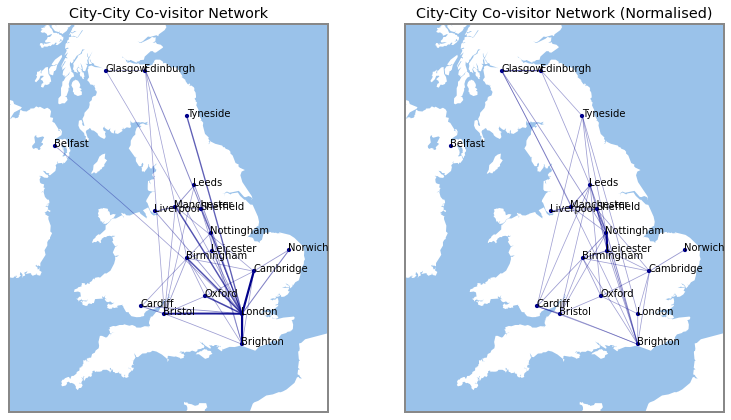

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.set_size_inches(20, 10)

#
# Compute city-to-city magnitudes
pairs = []
mags_covisitors = np.zeros([len(covis_counts)], np.float64)  # abs num co-visitors
mags_ratios = np.zeros([len(covis_counts)], np.float64)      # ratio s_ij / m_i * m_j
for indx, (pair, num_covisits) in enumerate(covis_counts.iteritems()):
    cA, cB = pair
    pairs.append(pair)
    mags_covisitors[indx] = num_covisits
    mags_ratios[indx] = num_covisits / (vis_counts[cA] * vis_counts[cB])

# alternatives: Gravity coefficient; Jaccard similarity?

#
# Gen params
color = 'darkblue'
percentile = 70
    
#
# General basemap params
params = {'llcrnrlon': -7.372070, 'llcrnrlat': 49.507377, 'urcrnrlon': 2.5, 'urcrnrlat': 56.7}  # all UK
#params = {'llcrnrlon': -5.972070, 'llcrnrlat': 49.807377, 'urcrnrlon': 2.0, 'urcrnrlat': 54.7}  # eng&wal


#
#
# Draw maps
#
for ax, mags in zip([ax1, ax2], [mags_covisitors, mags_ratios]):
    basem = default_basemap(ax=ax, draw_fua=False, draw_london=False, **params)
    
    # viz
    mag_viz_min = np.percentile(mags, percentile)
    
    max_lw = 2.5
    norm_lw = mpl.colors.Normalize(-max(mags)/2, max(mags)*1.2)

    norm_color = mpl.colors.Normalize(-max(mags)/1.8, max(mags))
    for (cA, cB), mag in zip(pairs, mags.flat):
        if mag <= mag_viz_min:
            continue
        basem.drawgreatcircle(cA.lon, cA.lat, cB.lon, cB.lat, c=color,
                              alpha=norm_color(mag),  #alpha=0.6, 
                              lw=norm_lw(mag)*max_lw)
    
    x, y = basem(df_cities['lon'].values, df_cities['lat'].values)
    sc = basem.scatter(x, y, s=18, marker='o', linewidths=0, c=color)  # 'RdYlBu' 'winter'
    
    for indx, row in df_cities.iterrows():
        x, y = basem(row.ix['lon'], row.ix['lat'])
        ax.text(x, y, shortname(row['name']))
    
    add_frame(ax, ec='k', lw=6.0)

ax1.set_title('City-City Co-visitor Network')
ax2.set_title('City-City Co-visitor Network (Normalised)')

#fig.tight_layout()
fig.set_size_inches(13, 7.0)
fig.savefig('out/uk_covisitors.pdf', bbox_inches='tight', pad_inches=0)

# taking top k-percentile here means that absences of links are also significant

In [28]:
import networkx as nx

g = nx.Graph()
for (cA, cB), mag in zip(pairs, np.array(mags_ratios)):
    g.add_edge(cA, cB, weight=mag)
    
node2cent = nx.katz_centrality(g)
for node, cent in sorted(node2cent.items(), key=lambda item: item[1], reverse=True):
    print cent, node

0.235708921502 UK::Nottingham-Derby metropolitan area
0.235706814653 UK::Leicester
0.235704025504 UK::Sheffield metropolitan area
0.235702634735 UK::Leeds - Bradford metropolitan area
0.235702506699 UK::Manchester metropolitan area
0.235702392984 UK::Birmingham metropolitan area
0.235702091213 UK::Glasgow
0.235702017492 UK::Edinburgh
0.235701964785 UK::Bristol metropolitan area
0.235701855889 UK::Brighton/Worthing/Littlehampton
0.235701641465 UK::Cardiff and South Wales valleys metropolitan area
0.235701106483 UK::Liverpool/Birkenhead metropolitan area
0.235701020259 UK::Cambridge
0.235700603379 UK::Tyneside metropolitan area
0.235700597151 UK::Oxford
0.235700459712 UK::London
0.235700348384 UK::Norwich
0.23569968464 UK::Belfast


# Topic modelling

## Build clustering of related groups via an LSA (hidden) topic model trained on keywords

The topic model will be trained on all 'active' groups.

### Feature extraction

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [30]:
# recall all_city2groups from earlier. this gives us the active groups in the
# UK, including those will filtered out.

groupname2doc = {}
seq_groups = sum(all_city2groups.values(), [])
corpus = []
for group in seq_groups:
    doc = []
    for topic in group['topics']:
        txt = topic['urlkey']
        assert ' ' not in txt
        doc.append(txt)
    corpus.append(doc)
    groupname2doc[group['name']] = doc
assert len(seq_groups) == len(corpus)

print "num groups", len(seq_groups)
print "num unique topics", len(frozenset(sum(corpus, [])))
corpus = [','.join(doc) for doc in corpus]

num groups 932
num unique topics 2068


In [31]:
def tokenizer(s):
    return s.split(',')

vectorizer = TfidfVectorizer(tokenizer=tokenizer)  #max_df=0.5,stop_words='english'#~
#vectorizer = CountVectorizer(tokenizer=tokenizer)  #max_df=0.5,stop_words='english'#~
X_tfidf = vectorizer.fit_transform(corpus)

X_tfidf.shape

feature_names = vectorizer.get_feature_names()

print X_tfidf.shape
print "num features ", len(feature_names)
print "num groups   ", len(seq_groups)

(932, 2068)
num features  2068
num groups    932


### Apply LSA -- Build latent topic space

In [60]:
lsa = TruncatedSVD(n_components=110)  # default=2
lsa = lsa.fit(X_tfidf)

print sum(lsa.explained_variance_ratio_ )
print lsa.explained_variance_ratio_[:10], '...?'

X_lsa = lsa.transform(X_tfidf)
X_lsa = Normalizer(copy=False).fit_transform(X_lsa)

print X_lsa.shape

0.660390826178
[ 0.0184302   0.02554936  0.02081859  0.01874351  0.01395618  0.01311155
  0.01251571  0.01123693  0.0105845   0.01030374] ...?
(932, 200)


### Group clustering -- number of clusters?

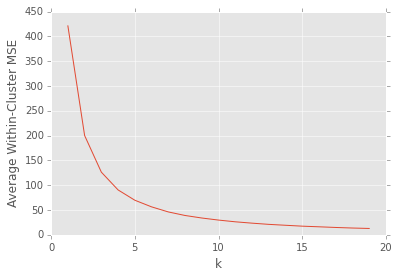

In [33]:
num_clusters = np.arange(1,20)
cluster_internal_err = np.zeros([num_clusters.size], np.float64)

for indx in xrange(num_clusters.size):
    k = num_clusters[indx]
    
    # compute k means and errs
    kmeans = KMeans(n_clusters=k, random_state=733)  #~ not cosine!
    labels = kmeans.fit_predict(X_lsa)
    
    # compute errs
    clust_errs = np.zeros([k])  # err in each cluster
    for clust_id in xrange(k):
        rows = X_lsa[labels==clust_id,:]
        dist_mat = sklearn.metrics.pairwise.cosine_distances(rows)  #~ cosine!
        err = np.sum(np.power(dist_mat, 2)/2.0) / rows.shape[0]  # mean squared error
        clust_errs[clust_id] = err
    cluster_internal_err[indx] = np.mean(clust_errs)

plt.plot(num_clusters, cluster_internal_err)
plt.ylabel('Average Within-Cluster MSE')
plt.xlabel('k')

### Chosen clustering

In [34]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=733)  #~ not cosine
labels = kmeans.fit_predict(X_lsa)

print labels.shape
print labels.min(), labels.max()

(932,)
0 6


[ 0.04697914  0.03606788  0.03467249]


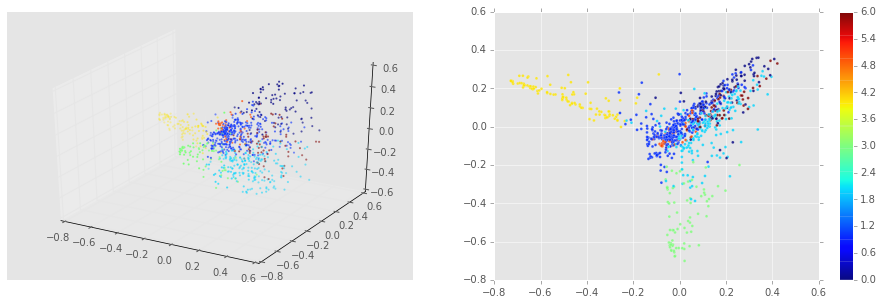

In [35]:
pca = sklearn.decomposition.PCA(n_components=3)
pca = pca.fit(X_lsa)
X_pca = pca.transform(X_lsa)
print pca.explained_variance_ratio_

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[16, 4.8])
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)
ax1.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=labels, s=4.5, lw=0.1)
sc = ax2.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=8, lw=0.2, alpha=0.8)

ax1.elev = 30    # default 30
ax1.azim = -60   # default -60

plt.colorbar(sc);

In [36]:
cluster2names = collections.defaultdict(lambda: [])
    # map cluster ID to list of group names belonging to cluster
    
cluster2rowindexes = collections.defaultdict(lambda: [])
    # map cluster ID to list of row indexes in the X_* matrices

for row_indx, (cluster_id, group) in enumerate(zip(labels, seq_groups)):
    cluster2rowindexes[cluster_id].append(row_indx)
    cluster2names[cluster_id].append(group['name'])

#
# finally, build assignment of groupid to clusterid
groupid2clusterid = dict(zip([group['id'] for group in seq_groups], labels))

In [37]:
def top_terms(row_indx, k=3):
    # return the top k terms and their weights
    vec = X_tfidf[row_indx,:]
    items = zip(feature_names, vec.toarray().flat)
    items.sort(key=lambda item: item[1], reverse=True)
    return items[:k]

cluster2clustername = {0: 'Web & Mobile', 1: 'Mixed/Unclassified',
                       2: 'DevOps, NoSQL, & Cloud', 3: 'Startups, Networking, & Soft Skills',
                       4: 'Makers', 5: 'Agile & Project Management', 6: 'Big Data & Data Science'}

print "latent topics  ", lsa.n_components
print "clusters       ", kmeans.n_clusters

print "\n=="
print "=="
print "==\n"

for clust_id, grp_names in cluster2names.iteritems():
    print clust_id, len(grp_names)

print "\n=="
print "=="
print "==\n"

for clust_id, grp_names in cluster2names.iteritems():
    row_indexes = cluster2rowindexes[clust_id]
    
    print "\n"
    print "="*80
    print 'CLUSTER %s    (%s groups)' % (clust_id, len(grp_names))
    print "Cluster name:", cluster2clustername[clust_id]
    print
    
    for name, row_indx in zip(grp_names, row_indexes):
        assert name == seq_groups[row_indx]['name']
        print name.upper(), "     [%d]" % groupid2clusterid[seq_groups[row_indx]['id']]
        print "   " + ', '.join("%s (%.2f)" % (term, tfidf) for term, tfidf in top_terms(row_indx, k=2))

latent topics   110
clusters        7

==
==
==

0 88
1 353
2 207
3 76
4 102
5 45
6 61

==
==
==



CLUSTER 0    (88 groups)
Cluster name: Web & Mobile

SYNCNORWICH - NORWICH'S TECH + STARTUP COMMUNITY      [0]
   angel-investors (0.45), startup-incubation-and-entrepreneurship-mentors (0.43)
SMALL BUSINESS WEST END      [0]
   coffee (0.46), seo-for-local-business (0.44)
SILICON CANAL MEETUP      [0]
   technology-professionals (0.41), internet-startups (0.37)
TECH EXECS BIRMINGHAM      [0]
   ceo-network (0.39), business-owners (0.37)
STARTUP TABLE FOOTBALL COMPETITION      [0]
   competition (0.42), foosball (0.42)
CLEANWEB SCOTLAND      [0]
   green-entrepreneurs (0.36), cleanweb (0.34)
PRODUCT FORGE      [0]
   product-development (0.44), product-management (0.39)
OXFORD INTERNET ENTREPRENEURS      [0]
   business-owners (0.37), small-business-networking (0.37)
STARTUP GRIND OXFORD      [0]
   startup-incubation-and-entrepreneurship-mentors (0.46), venture-capital (0.42)
LEICESTER 

## Build profile of each city according to group type

### Cit pre-processing, feature extraction

In [38]:
seq_cities = city2groups.keys()
    # NB not necessairly same ordering as mags_ratios

corpus = []
    # each doc is a city

for city in seq_cities:
    groups = city2groups[city]
    clust_ids = [groupid2clusterid[group['id']] for group in groups]
    doc = ','.join(map(str, clust_ids))
    corpus.append(doc)

In [39]:
def tokenizer(s):
    return s.split(',')

#vectorizer = TfidfVectorizer(tokenizer=tokenizer)  #max_df=0.5,stop_words='english'#~
vectorizer = CountVectorizer(tokenizer=tokenizer)  #max_df=0.5,stop_words='english'#~

X_count = vectorizer.fit_transform(corpus).astype(np.float64)
X_freq = X_count.copy()

for row in xrange(X_freq.shape[0]):
    X_freq[row,:] = X_freq[row,:] / X_freq[row,:].sum()

print X_freq.shape
for indx in range(len(seq_cities))[:5]:
    print seq_cities[indx]
    print X_freq.toarray()[indx,:]
print "..."

(18, 7)
UK::London
[ 0.1037415   0.38945578  0.18537415  0.08843537  0.1122449   0.04251701
  0.07823129]
UK::Brighton/Worthing/Littlehampton
[ 0.1   0.25  0.25  0.1   0.2   0.05  0.05]
UK::Bristol metropolitan area
[ 0.06818182  0.29545455  0.38636364  0.04545455  0.13636364  0.
  0.06818182]
UK::Edinburgh
[ 0.07692308  0.42307692  0.26923077  0.03846154  0.11538462  0.03846154
  0.03846154]
UK::Leeds - Bradford metropolitan area
[ 0.13333333  0.53333333  0.26666667  0.          0.          0.06666667
  0.        ]
...


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


### Cosine similarity between cities

In [40]:
cities_cosine_dist = sklearn.metrics.pairwise.cosine_distances(X_freq)

### Dimensionality reduction via PCA (and MDS cosine similarity for comparison)

[ 0.50689342  0.25449206  0.09834682]


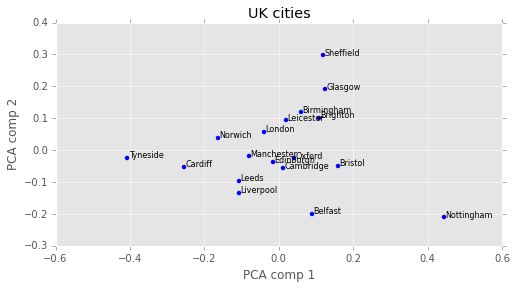

In [41]:
pca = sklearn.decomposition.PCA(n_components=3)  # PCA euclidian
X_pca = pca.fit_transform(X_freq.toarray())
print pca.explained_variance_ratio_
comp1 = X_pca[:,0]
comp2 =  X_pca[:,1]

fig, ax = plt.subplots(1, 1, figsize=[8,4])
sc = plt.scatter(comp1, comp2, linewidths=0)

plt.xlabel('PCA comp 1')
plt.ylabel('PCA comp 2')
plt.title('UK cities')

for x, y, name in zip(comp1, comp2, seq_cities):
    plt.annotate(shortname(name), xy=[x, y], fontsize=8, textcoords='offset points', xytext=[2, 0])


UK::London,   UK::Brighton/Worthing/Littlehampton,   UK::Bristol metropolitan area,   UK::Edinburgh,   UK::Leeds - Bradford metropolitan area,   UK::Liverpool/Birkenhead metropolitan area,   UK::Oxford,   UK::Leicester,   UK::Norwich,   UK::Manchester metropolitan area,   UK::Glasgow,   UK::Cambridge,   UK::Nottingham-Derby metropolitan area,   UK::Cardiff and South Wales valleys metropolitan area,   UK::Birmingham metropolitan area,   UK::Sheffield metropolitan area,   UK::Tyneside metropolitan area,   UK::Belfast
[[  61.  229.  109.   52.   66.   25.   46.]
 [   2.    5.    5.    2.    4.    1.    1.]
 [   3.   13.   17.    2.    6.    0.    3.]
 [   2.   11.    7.    1.    3.    1.    1.]
 [   2.    8.    4.    0.    0.    1.    0.]
 [   0.    6.    3.    0.    1.    1.    0.]
 [   2.    6.    5.    0.    2.    1.    0.]
 [   2.    3.    2.    0.    1.    0.    1.]
 [   1.    4.    1.    1.    0.    1.    0.]
 [   2.   18.    8.    3.    4.    1.    3.]
 [   1.    1.    1.    1.    

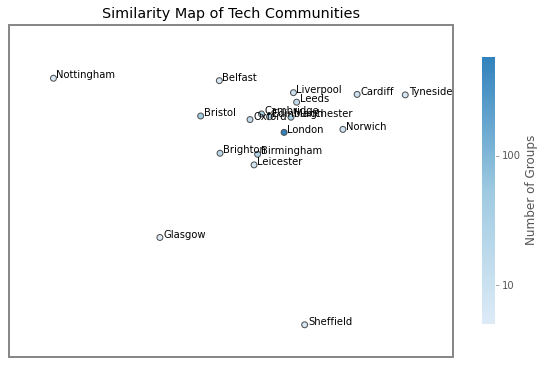

In [42]:
# seq_cities = city2groups.keys()
# co-ordered with...
#   cities_cosine_dist
#   X_freq
#   X_count

from sklearn.manifold import MDS
dist = sklearn.metrics.pairwise.cosine_distances(X_count.toarray())
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=2)
X_r = mds.fit_transform(dist)  # shape (n_components, n_samples)
comp1 = X_r[:,0]
comp2 =  X_r[:,1]

print ',   '.join(map(str, seq_cities))
print X_count.toarray()
for pair in zip(dist[0,:], map(str, seq_cities)):
    print pair

#print mds.explained_variance_ratio_

fig, ax = plt.subplots(1, 1, figsize=[10,6])

# add city names
for x, y, city_obj in zip(comp1, comp2, seq_cities):
    ax.annotate(shortname(city_obj), xy=[x, y], fontsize=10,
                textcoords='offset points', xytext=[4, 0])

# num groups per city
seq_num_groups = [float(len(city2groups[city])) for city in seq_cities]
norm = mpl.colors.LogNorm(vmin=5, vmax=max(seq_num_groups))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=palettable.colorbrewer.sequential.Blues_3.get_mpl_colormap())
seq_cols = map(cmap.to_rgba, seq_num_groups)

# plot components
sc = ax.scatter(comp1, comp2, s=35, facecolor=seq_cols, edgecolor='0.3', linewidths=1)

# cbar
cmap.set_array(seq_num_groups)
cbar = fig.colorbar(cmap, shrink=0.8)
cbar.set_label('Number of Groups')
cbar.formatter = mpl.ticker.FuncFormatter(lambda a, b: "%d" % a)
cbar.update_ticks()

# aesthetics
ax.set_xlabel('Comp 1')
ax.set_ylabel('Comp 2')
ax.set_title('Similarity Map of Tech Communities')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#ax.set_xlim(left=-.33, right=0.25);
#ax.set_ylim(bottom=-0.12, top=0.1);
ax.set_axis_bgcolor('w')
add_frame(ax, fc='none', ec='#888888', lw=5)

fig.savefig('out/cities_mds_similarity.pdf', bbox_inches='tight', pad_inches=0)
# distance between cities indicates similarity. closer more similar.
# angle has no meaning.

### Cities by meetup group types

In [43]:
#vectorizer
#X_freq
#X_counts

df_type_counts = pandas.DataFrame(X_count.toarray(),
    columns=[cluster2clustername[int(clust_id)] for clust_id in vectorizer.get_feature_names()],
    index=[shortname(c) for c in seq_cities])

print df_type_counts

print vectorizer.get_feature_names()  # cluster IDs (ints as strings)
df_type_freqs = pandas.DataFrame(X_freq.toarray(),
    columns=[cluster2clustername[int(clust_id)] for clust_id in vectorizer.get_feature_names()],
    index=[shortname(c) for c in seq_cities])

# sort
row_indxs = df_type_counts.sum(axis=1).argsort()[::-1]
df_type_counts = df_type_counts.iloc[row_indxs,:]
df_type_freqs = df_type_freqs.iloc[row_indxs,:]


            Web & Mobile  Mixed/Unclassified  DevOps, NoSQL, & Cloud  \
London                61                 229                     109   
Brighton               2                   5                       5   
Bristol                3                  13                      17   
Edinburgh              2                  11                       7   
Leeds                  2                   8                       4   
Liverpool              0                   6                       3   
Oxford                 2                   6                       5   
Leicester              2                   3                       2   
Norwich                1                   4                       1   
Manchester             2                  18                       8   
Glasgow                1                   1                       1   
Cambridge              2                  14                      10   
Nottingham             0                   1                    

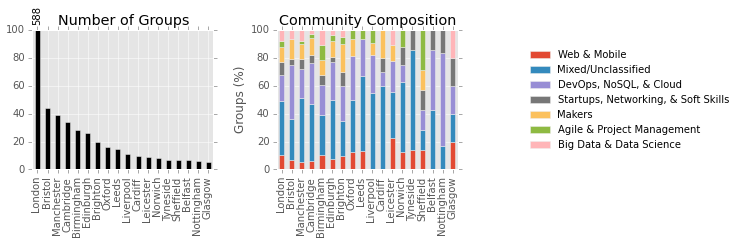

In [44]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=[12, 2.5])

# count of number of groups
df_counts = df_type_counts.sum(axis=1)
df_counts.plot(kind='bar', ax=ax1, color='k')
ax1.set_ylim(ymax=100)
ax1.text(0.1, 104, int(df_counts.ix['London']), rotation=90, ha='center', va='bottom')
#ax1.arrow(0.1, 0, 0.1, 64, int(df_counts.ix['London']), rotation=90, ha='center', va='bottom')
ax1.set_title("Number of Groups")

# proprtions in middle
(df_type_freqs*100).plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Community Composition')
ax2.set_ylim(ymax=100);
ax2.set_ylabel('Groups (%)')

# move legend to RHS
handles, labels = ax2.get_legend_handles_labels()
ax3.legend(handles=handles, fontsize='medium', frameon=False, loc='center left')
ax3.axis('off')
ax2.legend_.remove()

#fig.tight_layout()
fig.subplots_adjust(wspace=0.35)

fig.savefig('out/uk_num_groups_bar_charts.pdf', bbox_inches='tight', pad_inches=0.1)

# The map of events, by group type

In [45]:
cluster_ids = sorted(set(cluster2rowindexes.keys()))

norm = mpl.colors.Normalize(vmin=min(cluster_ids), vmax=max(cluster_ids))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='Set1')
clusterid2color = {cid: cmap.to_rgba(cid) for cid in cluster_ids}

In [46]:
seq_lon = []
seq_lat = []
seq_col = []
for group in seq_groups:
    for event in group['events_in_window']:
        if 'venue' not in event:
            continue
        venue = event['venue']
        seq_lon.append(venue['lon'])
        seq_lat.append(venue['lat'])
        clust_id = groupid2clusterid[group['id']]
        seq_col.append(clusterid2color[clust_id])

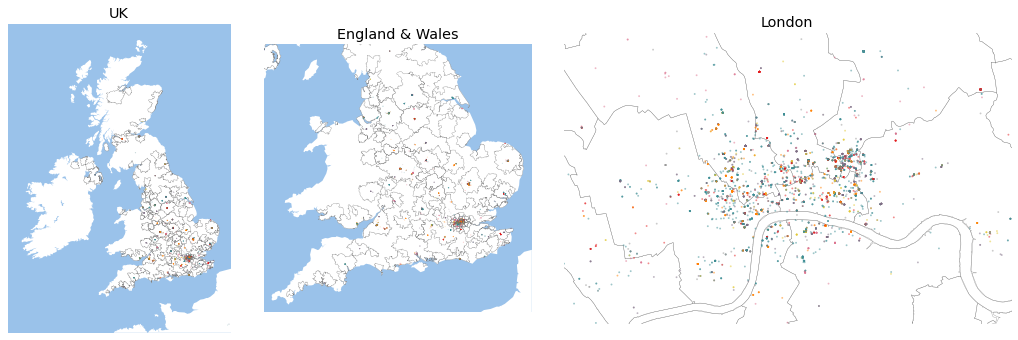

In [47]:

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset 

#
# Basemap
fig = plt.figure(figsize=[18, 12])
#gs = mpl.gridspec.GridSpec(2, 3, wspace=0.02, hspace=0.01)
#ax1 = plt.subplot(gs[:,:-1])
#ax2 = plt.subplot(gs[0,-1])
#ax3 = plt.subplot(gs[1,-1])
gs = mpl.gridspec.GridSpec(1, 3, wspace=0.10, hspace=0.01, width_ratios=[5, 6, 10])
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])

viewports = [
    {'llcrnrlon': -11.372070, 'llcrnrlat': 48.507377, 'urcrnrlon': 2.5, 'urcrnrlat': 59.7},  # UK
    {'llcrnrlon': -5.972070, 'llcrnrlat': 49.807377, 'urcrnrlon': 2.0, 'urcrnrlat': 54.7},  # eng&wal
    {'llcrnrlon': -0.206744, 'llcrnrlat': 51.48, 'urcrnrlon': -0.01, 'urcrnrlat': 51.560},  # Central London
    ]

for ax, view, s, alpha in zip([ax1, ax2, ax3], viewports, [1.5, 1.5, 3.5], [0.2, 0.2, 0.5]):
    basem = default_basemap(ax=ax, draw_fua=True, draw_london=True,**view)
    #basem = Basemap(rsphere=(6378137.00, 6356752.3142),
    #                resolution='i', projection='merc',
    #                lat_0=40., lon_0=-20., lat_ts=20., ax=ax,
    #                **view)
    #basem.drawcoastlines(color=[0, 0, 0, 0.4])

    x, y = basem(seq_lon, seq_lat)
    
    basem.scatter(x, y, s=s, marker='o', linewidths=0, c=seq_col, alpha=alpha)
    #basem.hexbin(np.array(x), np.array(y), mincnt=1, cmap='winter_r', gridsize=1000)

ax1.set_title('UK')
ax2.set_title('England & Wales')
ax3.set_title('London')


# Similarity vs geography

In [48]:
# inputs (computed earlier)...
#
# seq_cities = city2groups.keys()
# co-ordered with...
#   cities_cosine_dist
#   X_freq


In [49]:
pairwise_covis_ratios = {}
pairwise_cosine_dists = {}
for i, cA in enumerate(seq_cities):
    for j, cB in enumerate(seq_cities):
        if i < j:
            pair = (cA, cB)
            ratio = covis_counts[pair] / float(vis_counts[cA] * vis_counts[cB])
            pairwise_covis_ratios[pair] = ratio
            pairwise_cosine_dists[pair] = cities_cosine_dist[i,j]
        

In [50]:
seq_dists = []
seq_ratios = []
for pair in pairwise_covis_ratios.keys():
    seq_ratios.append(pairwise_covis_ratios[pair])
    seq_dists.append(pairwise_cosine_dists[pair])
seq_ratios = np.array(seq_ratios)
seq_ratios = seq_ratios / seq_ratios.max()
print len(x)

11099


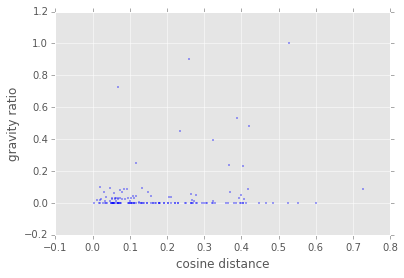

In [51]:
fig, ax = plt.subplots(1, 1)
ax.scatter(seq_dists, seq_ratios, marker='x', s=1.0)
ax.set_xlabel('cosine distance')
ax.set_ylabel('gravity ratio')

In [52]:
# Comparison with naive approach -- PCA on city tag counts

In [53]:
# Combined interactive map
# mpld3.enable_notebook()